# Chapter 4 Training Models

## Linear Regression

A linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term*: 

$$ \hat{y}=\theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $$

In this equation: $\hat{y}$ is the predicted value, $n$ is the number of features, $x_i$ is the i-th feature value, and $\theta_j$ is the j-th model parameter (including the bias term $\theta_0$).

In vectorized form:
$$ \hat{y} = h_{\mathbf{\theta}}(\mathbf{x})=\mathbf{\theta}\cdot\mathbf{x} $$

If $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors, then the prediction is $\hat{y}=\mathbf{\theta}^{\text{T}}\mathbf{x}$, where $\mathbf{\theta}^{\text{T}}$ is the transpose of $\mathbf{\theta}$ and $\mathbf{\theta}^{\text{T}}\mathbf{x}$ is the matrix multiplication of the two vectors.

In order to train a linear regression model we first need a measure of how well the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE). We need to find the value of $\mathbf{\theta}$ that minimizes the RMSE. Usually it's simpler to minimize the mean squared error (MSE) rather than the RMSE.

The MSE of a linear regression hypothesis $h_{\mathbf{\theta}}$ on a training set $\mathbf{X}$ is:

$$ MSE(\mathbf{X}, h_{\mathbf{\theta}})=\frac{1}{m}\sum^{m}_{i=1}\big(\mathbf{\theta}^{\text{T}}\mathbf{x}^{(i)}-y^{(i)}\big)^{2}$$

To find the value of $\mathbf{\theta}$ that minimizes the cost function, there is a analytical solution known as the *Normal Equation*.

$$ \hat{\mathbf{\theta}}=(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{y} $$

There are also iterative methods which we will look at later. 

Let's use the normal equation to perform regression on some test data in Python:

(0.0, 2.0, 0.0, 15.0)

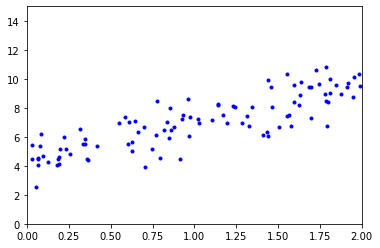

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])

In [2]:
X_b = np.c_[np.ones((100, 1)), X]  # adds x0 = 1 to each set of x features
print(X_b[:5])

[[1.         0.54914635]
 [1.         0.083206  ]
 [1.         1.10742822]
 [1.         0.64382963]
 [1.         0.03301831]]


In [3]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.39189079],
       [2.58590122]])

Note that function that we just used to generate the data is $y=4+3x_{1}+\text{Gaussian noise}$. Now we can make predictions using $\hat{\mathbf{\theta}}$:

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.39189079],
       [9.56369322]])

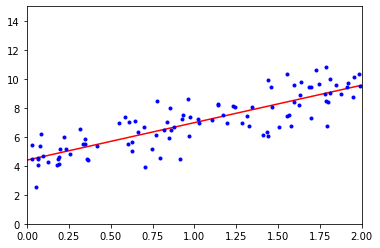

In [5]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

We can also perform linear regression with Scikit-Learn:

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.39189079]), array([[2.58590122]]))

In [7]:
lin_reg.predict(X_new)

array([[4.39189079],
       [9.56369322]])

The `LinearRegression` class is actually based on the `scipy.linalg.lstsq()` function. We can call that directly too:

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.39189079],
       [2.58590122]])

The `scipy.linalg.lstsq()` function computes $\hat{\mathbf{\theta}}=\mathbf{X}^{+}\mathbf{y}$, where $\mathbf{X}^{+}$ is the *pseudoinverse* of $\mathbf{X}$. We can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[4.39189079],
       [2.58590122]])

The pseudoinverse is computed using a technique called *Singular Value Decomposition (SVD)*.

## Computational Complexity

Clearly, the normal equation computes the inverse of $\mathbf{X}^{\text{T}}\mathbf{X}$, but this is an $(n+1)\times (n+1)$ matrix (where $n$ is the number of features).

The computational complexity of inverting such a matrix is typically $O(n^{2.4})$ to $O(n^{3})$. On the other hand, the *Singular Value Decomposition (SVD)* approach used by Scikit-Learn's `LinearRegression` class does it with about $O(n^2)$ complexity. 

>While both the Normal Equation and SVD approach get very slow with increasing number of features, both are linear with regard to the number of instances in the training set (they are $O(m)$), so they can handle large training sets efficiently, provided they can fit in memory.

Making *predictions* with a trained model, however, is very fast (almost linear).

When there are a large number of features or too many training instances to fit in memory we have to get creative in order to reduce computational complexity and the training time.

## Gradient Descent

Gradient descent is an iterative optimization algorithm that works by tweaking parameters and simultaneously minimizing a cost function.

How does gradient descent work?: It measures the local gradient of the error function (Calculus vibes) with respect to the parameter vector $\mathbf{\theta}$ and changes the parameters in the direction of the descending gradient. Once the gradient reaches zero, the function is minimized.

Usually, $\mathbf{\theta}$ is populated with random values (*random initialization*). The parameters are tweaked slightly with the goal of decreasing the cost function (MSE, for example) until *convergence*.

The size of the tweaks to the parameters $\mathbf{\theta}$ is deteremined by the *learning rate* hyperparameter. Getting the right learning rate is a balancing act: too small and the algortihm will take a long time to converge, and too large and the algorithm may diverge.

#### Not all cost functions are simple to minimize. 

They may have local minima which make gradient descent's job a lot harder. The algorithm may converge to a local minimum rather than the global one. Fortunately MSE for a LINEAR REGRESSION model is a *convex function*, meaning that the line segment between any two points on the curve never crosses the curve. This implies that there is only one minimum, and it's a global one. MSE is also a continuous function with a slope that does not change abruptly.

All of these facts lead to one thing: gradient descent is guaranteed to approach arbitratiliy close to the global minimum!

When using gradient descent, all features should have a similar scale or it will take longer to converge. The `StandardScaler` class in Scikit-Learn will do this for us.

Training a model with gradient descent means searching for a combination of parameters within the parameter space that minimizes a cost function.

### Batch Gradient Descent

To implement gradient descent we compute the gradient of the cost function with respect to *each* model parameter $\theta_j$:

$$ \frac{\partial}{\partial \theta_j} MSE(\mathbf{\theta})=\frac{2}{m}\sum^m_{i=1}\Big(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)}\Big)x_{j}^{(i)}$$

Instead of computing this partial derivative for each and every model parameter, we can compute the gradient vector instead:

$$ \nabla_{\theta}MSE(\mathbf{\theta})= \begin{pmatrix}
\frac{\partial}{\partial \theta_0} MSE(\mathbf{\theta})\\
\frac{\partial}{\partial \theta_1} MSE(\mathbf{\theta})\\
\vdots\\
\frac{\partial}{\partial \theta_n} MSE(\mathbf{\theta})
\end{pmatrix} = \frac{2}{m}\mathbf{X}^{T}(\mathbf{X}\mathbf{\theta}-\mathbf{y})$$

>Notice that this formula involves calculations over the entire training set $\mathbf{X}$ at each gradient descent step. Because the whole batch of training data is used at every step, this algorithm is very slow on large training sets. However, gradient descent scales well iwth the number of features; training a linear regression model when there are hundreds of thousands of features is still much faster using gradient descent than using the normal equation of singular value decomposition!

The gradient vector in its current form points in the direction of greatest increase, so to go downhill we just subtract it from $\mathbf{\theta}$. Remember that the gradient vector is just a slope though, we need to multiply it by some constant to figure out how big of a step we will take! This is where we introduce the learning rate $\eta$. We multiply $\eta$ with the gradient vector to determine the size of the downhill step and then subtract that from $\theta$, giving us a $\theta$ that is slightly better than the previous:

$$ \mathbf\theta^{\text{next step}}=\mathbf{\theta}-\eta\nabla_{\theta}MSE(\mathbf{\theta}) $$

We can implement gradient descent really quickly in Python:

In [10]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  
# random initialization of theta, i.e. the parameter space which includes the 
# slope and intercept of the line we previously looked at

for i in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta*gradient

theta

array([[4.39189079],
       [2.58590122]])

This is exactly what the normal equation found!

## Stochastic Gradient Descent

The main problem with batch gradient descent is that it uses the entire training set to compoute the gradients at every iteration, making it very slow when we have a large training set.

On the other hand, *stochastic* gradient descent picks a random instance in the training set at every step and computes the gradients based on that single instance. This makes the algorithm much faster and able to run on huge training sets.

The stochastic nature of the algorithm means that it is less regular--the cost function bounces up and down, decreasing on average, but not every step. Eventually, the algorithm reaches near the minimum but continues to bounce around. The final parameters are then good, but not optimal.

However, jumping around with the cost function can help the algorithm exit local minima, so stochastic gradient descent is better at finding the global minimum than batch gradient descent.

One solution to the fact that stochastic gradient descent can never settle at the minimum is to gradually reduce the learning rate, $\eta$. The steps start out large, then get smaller, alllowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*.

If the learning rate is reduced too quickly, the algorithm can get stuck in a local minimum. On the other hand, reducing it too slowly may cause the algorithm to jump around the minimum for a long time and we may end up with a suboptimal solution if training is stopped too early. 

We can implement stochastic gradient descent easily in Python:

In [14]:
n_epochs = 50
t0, t1 = 5, 50  # hyperparameters for the learning schedule

def learning_schedule(t0, t1, t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t0, t1, epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[4.40195492],
       [2.61650564]])

We iterated by rounds of *m* iterations; each round is called an epoch. While the batch gradient descent code iterated 1000 times through the whole training set, this code wnet through the training set only 50 times and still got a decent solution.

>When using stochastic gradient descent, the training instances need to be independent and identically distributed to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training. If we don't shuffle the instances, then SGD starts optimizing for one label, then the next, and so on. In doing this it does not settle close to the global minimum.

To perform linear regression using stochastic gradient descent with Scikit-Learn, we can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. The following code runs for a maximum of 1000 epochs or until the loss drops by less than 0.001 during one epoch, starting with a learning rate of 0.1, and using the default learning schedule:

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())  # ravel returns a flattened array

sgd_reg.intercept_, sgd_reg.coef_

(array([4.42791198]), array([2.61604254]))

## Mini-batch Gradient Descent